In [1]:
%matplotlib inline
from __future__ import division
from fileoperations.fileoperations import get_filenames_in_dir
from symbtrdataextractor.dataextractor import DataExtractor
import os 
import json
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json


# I/O

In [2]:
sim_thresholds = np.arange(0, 1.001, 0.05)

# get the dataset
txt_folder = os.path.join('turkish_makam_section_dataset', 'txt')
txt_files, txt_folders, txt_names = get_filenames_in_dir(txt_folder, keyword='*.txt')
txt_names = [os.path.splitext(tn)[0] for tn in txt_names]

anno_folder = os.path.join('turkish_makam_section_dataset', 'sections')
save_basefolder = 'experiments'

structure_names = ['melodic_structure', 'lyric_structure']

# Define the wrapper function for experiments

In [3]:
def section_extractor_wrapper(sim_thres):
    # instantiate the extractor
    extractor = DataExtractor(melody_sim_thres=sim_thres, lyrics_sim_thres=sim_thres, 
                              print_warnings=False)

    # initialize the results dictionary
    res_eval = {k:{'overall':{'num_sections':0, 'num_true':0, 'accuracy':-1}, 
                   'per_score':[]} for k in structure_names}

    # apply section extraction and analysis to each file
    for tt, tn in zip(txt_files, txt_names):
        # extract ...
        data, is_valid = extractor.extract(tt)
        assert is_valid, '%s has errors' % tt

        # process the sections
        df = pandas.DataFrame.from_dict(data['sections'])
        df = df.reindex_axis(['start_note', 'end_note', 'name', 'melodic_structure', 
                              'lyric_structure' , 'lyrics', 'slug'], axis=1)

        # save results
        save_folder = os.path.join(save_basefolder, str(sim_thres).replace('.', '_'))
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        save_file = os.path.join(save_folder, tn + '.csv')
        df.to_csv(open(save_file, 'w'), sep='\t', encoding='utf-8', 
                  index=False)

        # evaluate
        anno_file = os.path.join(anno_folder, tn + '.csv')
        anno_df = pandas.read_csv(anno_file, sep='\t', encoding='utf-8')
        for st in structure_names:
            eval_arr = (anno_df[st] == df[st])
            res_eval[st]['per_score'].append(
                {'num_sections':len(eval_arr), 'num_true':sum(eval_arr),
                 'accuracy':eval_arr.mean(), 'score':tn})

            res_eval[st]['overall']['num_sections'] += len(eval_arr)
            res_eval[st]['overall']['num_true'] += sum(eval_arr)

    for st in structure_names:
        res_eval[st]['overall']['accuracy'] = (res_eval[st]['overall']['num_true']  / 
                                               res_eval[st]['overall']['num_sections'])
        
    return res_eval

# Conduct experiments and aggregate the results


In [4]:
eval_dict = {}
av_mel = []  # average melodic structure accuracy
av_lyr = []  # average lyric structure accuracy
per_mel = []  # melodic structure accuracy per score
per_lyr = []  # lyric structure accuracy per score
sim_threshold_strs = []
for th in sim_thresholds:
    th_str = str('%.2f' % th)
    sim_threshold_strs.append(th_str)
    eval_dict[th_str] = section_extractor_wrapper(th)
    
    av_mel.append(eval_dict[th_str]['melodic_structure']['overall']['accuracy'])
    av_lyr.append(eval_dict[th_str]['lyric_structure']['overall']['accuracy'])
    
    per_mel.append([mel['accuracy'] 
                   for mel in eval_dict[th_str]['melodic_structure']['per_score']])
    per_lyr.append([lyr['accuracy'] 
                   for lyr in eval_dict[th_str]['lyric_structure']['per_score']])
    
    print '%s: %.2f, %.2f' % (th, av_mel[-1], av_lyr[-1])

json.dump(eval_dict, open(os.path.join(save_basefolder, 'results.json'), 'w'))

0.0: 0.15, 0.70
0.05: 0.11, 0.75
0.1: 0.11, 0.75
0.15: 0.15, 0.75
0.2: 0.19, 0.77
0.25: 0.34, 0.82
0.3: 0.51, 0.88
0.35: 0.61, 0.94
0.4: 0.72, 0.97
0.45: 0.78, 0.98
0.5: 0.85, 1.00
0.55: 0.92, 1.00
0.6: 0.93, 1.00
0.65: 0.97, 1.00
0.7: 0.99, 1.00
0.75: 0.97, 0.99
0.8: 0.92, 1.00
0.85: 0.85, 1.00
0.9: 0.78, 0.99
0.95: 0.64, 0.99
1.0: 0.58, 0.99


# Plot Results

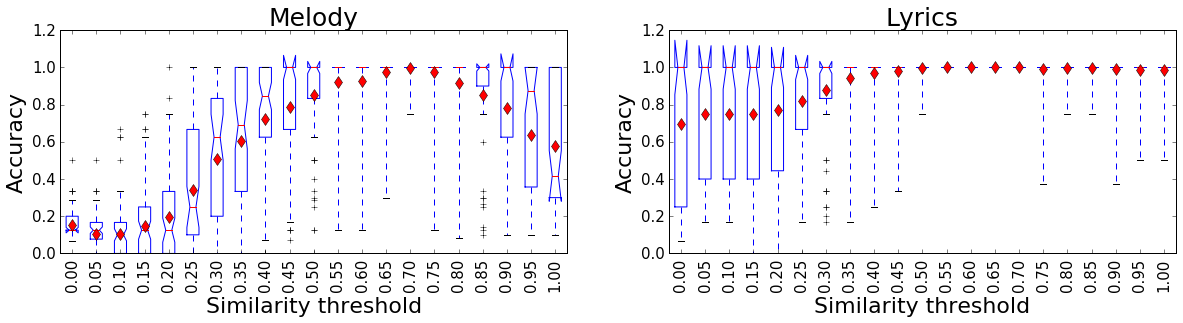

In [5]:
matplotlib.rcParams['figure.figsize'] = (20, 4)
matplotlib.rcParams['ytick.labelsize'] = 15 
matplotlib.rcParams['xtick.labelsize'] = 15 

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(per_mel, notch=True)
ax1.plot(np.arange(1, len(av_mel)+1), av_mel, 'rd', ms=9)

ax1.set_xticklabels(sim_threshold_strs)
ax1.set_xlabel('Similarity threshold', fontsize = 22)
ax1.set_ylabel('Accuracy', fontsize = 22)
ax1.set_title('Melody', fontsize = 25)
matplotlib.pyplot.sca(ax1)
plt.xticks(rotation=90)

ax2.boxplot(per_lyr, notch=True)
ax2.plot(np.arange(1, len(av_lyr)+1), av_lyr, 'rd', ms=9)

ax2.set_xticklabels(sim_threshold_strs)
ax2.set_xlabel('Similarity threshold', fontsize = 22)
ax2.set_ylabel('Accuracy', fontsize = 22)
ax2.set_title('Lyrics', fontsize = 25)

matplotlib.pyplot.sca(ax2)
plt.xticks(rotation=90)
# plt.savefig(os.path.join(save_basefolder, "boxplot.pdf"))
plt.show()